# Analysing performance and solutions as time constants change

This builds on [Optimizing-Membrane-Time-Constant.ipynb](./Optimizing-Membrane-Time-Constant.ipynb) and [3-Starting-Notebook.ipynb](./3-Starting-Notebook.ipynb), see those notebooks for background.

## Imports and setup

In [16]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

## Data generation

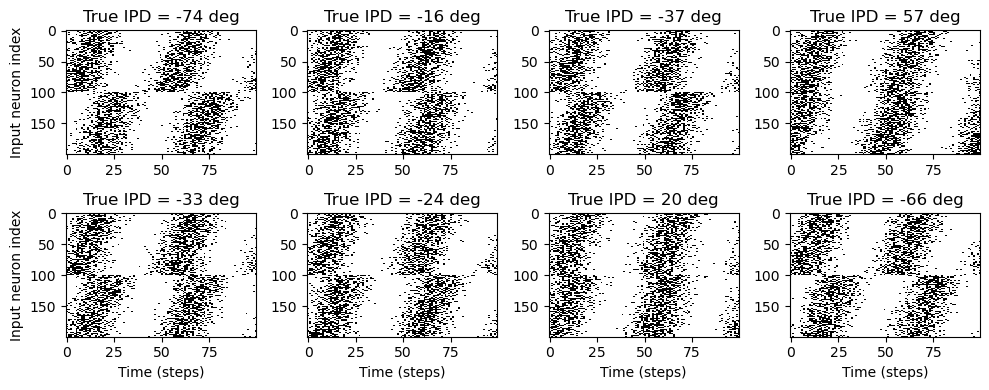

In [22]:
class ITDDataset(torch.utils.data.Dataset):
    def __init__(self,
                 num_samples,
                 dt=1*ms,             # large time step to make simulations run faster for tutorial
                 anf_per_ear=100,     # repeats of each ear with independent noise
                 envelope_power=2,    # higher values make sharper envelopes, easier
                 rate_max=600*Hz,     # maximum Poisson firing rate
                 f=20*Hz,             # stimulus frequency
                 duration=.1*second,  # stimulus duration
                 num_classes=180//15, # number of IPD classes for discretisation
                 batch_size=128,
                 shuffle=True,
                 ):
        self.num_samples = num_samples
        self.dt = dt
        self.anf_per_ear = anf_per_ear
        self.envelope_power = envelope_power
        self.rate_max = rate_max
        self.f = f
        self.duration = duration
        self.duration_steps = int(np.round(duration/dt))
        self.input_size = 2*anf_per_ear
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ipd, self.spikes = self.random_ipd_input_signal()
        self.data_loader = torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle)

    # Generate an input signal (spike array) from array of true IPDs
    def input_signal(self, ipd):
        num_samples = len(ipd)
        T = np.arange(self.duration_steps)*self.dt # array of times
        phi = 2*np.pi*(self.f*T+np.random.rand()) # array of phases corresponding to those times with random offset
        # each point in the array will have a different phase based on which ear it is
        # and its delay
        theta = np.zeros((num_samples, self.duration_steps, 2*self.anf_per_ear))
        # for each ear, we have anf_per_ear different phase delays from to pi/2 so
        # that the differences between the two ears can cover the full range from -pi/2 to pi/2
        phase_delays = np.linspace(0, np.pi/2, self.anf_per_ear)
        # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
        # but implements the idea in the text above.
        theta[:, :, :self.anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
        theta[:, :, self.anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
        # now generate Poisson spikes at the given firing rate as in the previous notebook
        spikes = np.random.rand(num_samples, self.duration_steps, 2*self.anf_per_ear)<self.rate_max*self.dt*(0.5*(1+np.sin(theta)))**self.envelope_power
        return spikes

    # Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    def random_ipd_input_signal(self):
        ipd = np.random.rand(self.num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
        spikes = self.input_signal(ipd)
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        return ipd, spikes
    
    def discretise(self, ipds):
        return ((ipds+np.pi/2)*self.num_classes/np.pi).long() # assumes input is tensor

    def continuise(self, ipd_indices): # convert indices back to IPD midpoints
        return (ipd_indices+0.5)/self.num_classes*np.pi-np.pi/2    
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.spikes[idx, :, :], self.discretise(self.ipd[idx])
    
    def visualise(self, w=4, h=2):
        N = w*h
        # Plot a few just to show how it looks
        spikes = self.spikes.cpu()
        plt.figure(figsize=(10, 4), dpi=100)
        for i in range(N):
            plt.subplot(h, w, i+1)
            plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            plt.title(f'True IPD = {int(self.ipd[i]*180/np.pi)} deg')
            if i>=4:
                plt.xlabel('Time (steps)')
            if i%4==0:
                plt.ylabel('Input neuron index')
        plt.tight_layout()


train_data = ITDDataset(num_samples=128*128, batch_size=128)
test_data = ITDDataset(num_samples=32*128, batch_size=128)
test_data.visualise()

## Model

### Surrogate gradient function

In [42]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        beta = 5
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

### Spiking neural network

In [35]:
class ITDNet(nn.Module):
    def __init__(self, dataset, num_hidden=30, tau=20*ms, dt=1*ms):
        super(ITDNet, self).__init__()
        self.input_size = dataset.input_size
        self.num_classes = dataset.num_classes
        self.num_hidden = num_hidden
        self.tau = tau
        self.dt = dt
        self.init_weight_matrices()

    # Weights and uniform weight initialisation
    def init_weight_matrices(self):
        # Input to hidden layer
        self.W_ih = nn.Parameter(torch.empty((self.input_size, self.num_hidden), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ih)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ih, -bound, bound)
        # Hidden layer to output
        self.W_ho = nn.Parameter(torch.empty((self.num_hidden, self.num_classes), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ho)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ho, -bound, bound)
        return self.W_ih, self.W_ho
        
    def forward(self, input_spikes):
        batch_size, duration_steps, input_size = input_spikes.shape
        if input_size!=self.input_size:
            raise ValueError(f"Expected input size {self.input_size} but got {input_size}")
        # First layer: input to hidden
        v = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s_rec = [s]
        h = torch.einsum("abc,cd->abd", (input_spikes, self.W_ih))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
            s = spike_fn(v-1) # threshold of 1
            v = new_v
            s_rec.append(s)
        s_rec = torch.stack(s_rec, dim=1)
        # Second layer: hidden to output
        v = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        v_rec = [v]
        h = torch.einsum("abc,cd->abd", (s_rec, self.W_ho))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            v = alpha*v + h[:, t, :]
            v_rec.append(v)
        v_rec = torch.stack(v_rec, dim=1)
        # Return softmax of mean recorded membrane potential of output
        m = torch.mean(v_rec, 1)  # Mean across time dimension
        log_softmax_fn = nn.LogSoftmax(dim=1)
        return log_softmax_fn(m)

    def train(self, nb_epochs=10, lr=0.01):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.NLLLoss()
        # training loop
        print(f"Want loss for epoch 1 to be about {-np.log(1/train_data.num_classes):.2f}, multiply m by constant to get this")
        loss_hist = []
        for e in range(nb_epochs):
            local_loss = []
            for spikes, ipds in train_data.data_loader:
                # Run network
                output = self(spikes)
                loss = loss_fn(output, ipds)
                local_loss.append(loss.item())
                # Update gradients
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_hist.append(np.mean(local_loss))
            print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        return loss_hist

## Training

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.91832
Epoch 2: loss=1.02286
Epoch 3: loss=0.77117
Epoch 4: loss=0.65209
Epoch 5: loss=0.58420
Epoch 6: loss=0.53515
Epoch 7: loss=0.51457
Epoch 8: loss=0.48786
Epoch 9: loss=0.46023
Epoch 10: loss=0.44348


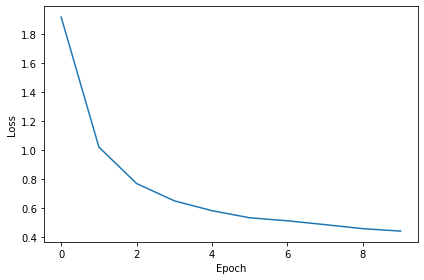

In [50]:
net = ITDNet(train_data)
loss_hist = net.train(nb_epochs=10)

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

## Analysis of trained network

Chance accuracy level: 8.3%

Train classifier accuracy: 82.8%
Train absolute error: 2.6 deg

Test classifier accuracy: 48.4%
Test absolute error: 10.3 deg


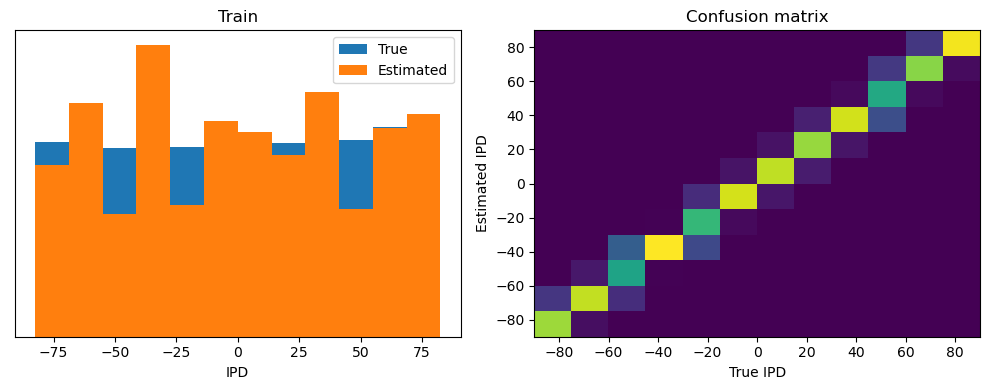

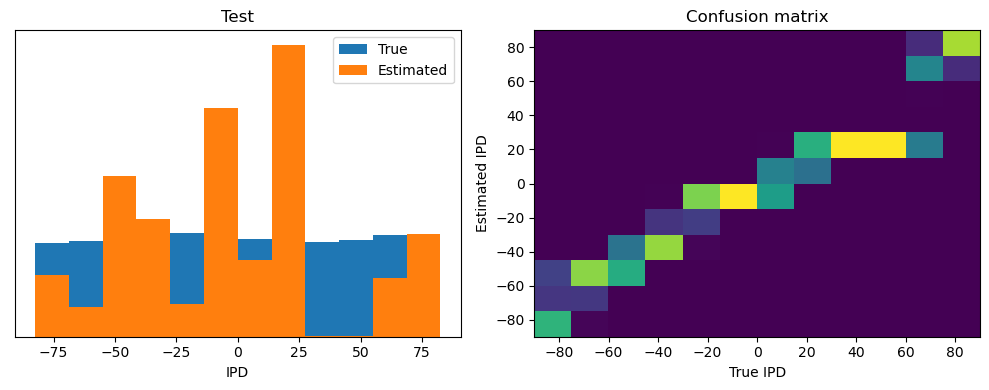

In [51]:
def analyse(model, dataset, label):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((dataset.num_classes, dataset.num_classes))
    for x_local, y_local in dataset.data_loader:
        with torch.no_grad():
            output = model(x_local)
        _, am = torch.max(output, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(dataset.continuise(y_local.detach().cpu().numpy()))
        ipd_est.append(dataset.continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=dataset.num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=dataset.num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()

# Analyse
print(f"Chance accuracy level: {100*1/train_data.num_classes:.1f}%")
analyse(net, train_data, 'Train')
analyse(net, test_data, 'Test')

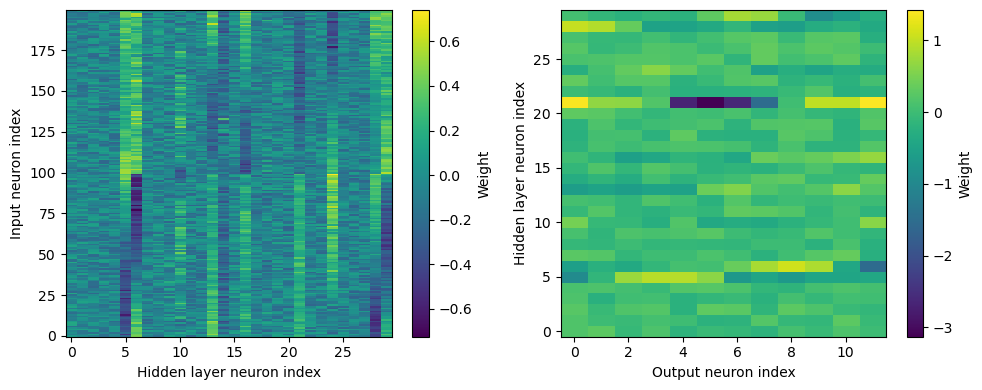

In [13]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

Hmm, hard to interpret.


Here's what I've got so far...

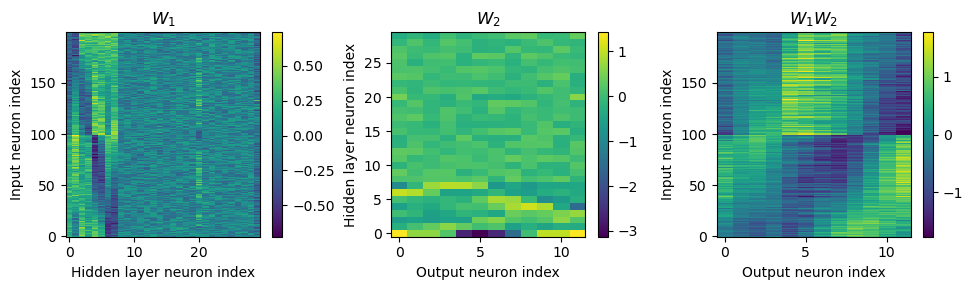

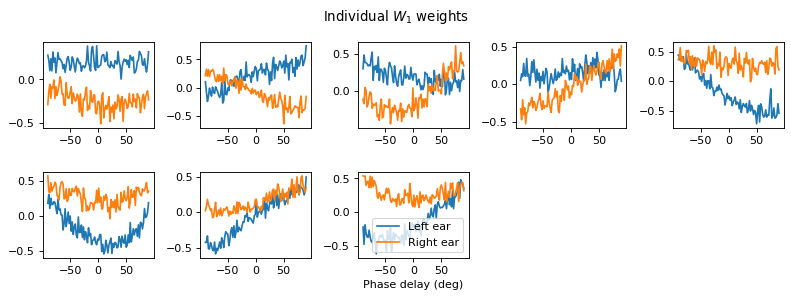

In [14]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

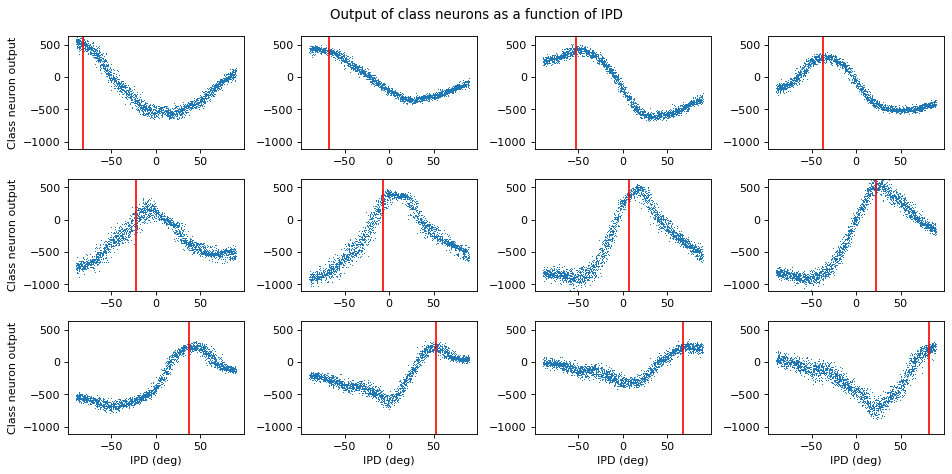

In [15]:
# ipds_test shape (num_samples)
# spikes_test shape (num_samples, duration_steps, 2*anf_per_ear)
all_m = []
all_ipd = []
for x_local, y_local in data_generator(ipds_test, spikes_test):
    output = snn(x_local, W1, W2) # shape (batch_size, duration_steps, num_classes)
    m = torch.sum(output, 1) # shape (batch_size, num_classes)
#     m = log_softmax_fn(m)
    all_m.append(m)
    all_ipd.append(y_local)
cls_output = torch.cat(all_m, 0).detach().cpu().numpy() # shape (num_samples, num_classes)
ipds_ = torch.cat(all_ipd).detach().cpu().numpy()

plt.figure(figsize=(12, 6), dpi=80)
for i in range(num_classes):
    plt.subplot(3, 4, i+1)
    plt.plot(ipds_*180/np.pi, cls_output[:, i], ',')
    plt.axvline(continuise(i)*180/np.pi, ls='-', c='r')
    if i//4==2:
        plt.xlabel('IPD (deg)')
    if i%4==0:
        plt.ylabel('Class neuron output')
    plt.ylim(cls_output.min(), cls_output.max())
plt.suptitle("Output of class neurons as a function of IPD")
plt.tight_layout()